In [4]:
%load_ext autoreload
%autoreload 2

import os
os.environ['AEON_DEPRECATION_WARNING'] = 'False'
os.environ['KMP_WARNINGS'] = 'off'

import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

from utils import *

import sys
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Shows files

In [8]:
config_names = ["SAX",
                "SOFA+ED",
                "SOFA+EW",
                "SPARTAN+ED",
                "SPARTAN+EW",                
               ]

        
path = "logs/MESSI_SFA_logs_spartan"
all_files = read_logs(log_type="query", path=path, config_names = config_names)

Config logs/MESSI_SFA_logs_spartan/ASTRO/36
-----------------
Config logs/MESSI_SFA_logs_spartan/BIGANN/36
-----------------
Config logs/MESSI_SFA_logs_spartan/DEEP1b/36
-----------------
Config logs/MESSI_SFA_logs_spartan/ETHC/36
-----------------
Config logs/MESSI_SFA_logs_spartan/ISC_EHB_DepthPhases/36
-----------------
Config logs/MESSI_SFA_logs_spartan/Iquique/36
-----------------
Config logs/MESSI_SFA_logs_spartan/LenDB/36
-----------------
Config logs/MESSI_SFA_logs_spartan/Meier2019JGR/36
-----------------
Config logs/MESSI_SFA_logs_spartan/NEIC/36
-----------------
Config logs/MESSI_SFA_logs_spartan/OBS/36
-----------------
Config logs/MESSI_SFA_logs_spartan/OBST2024/36
-----------------
Config logs/MESSI_SFA_logs_spartan/PNW/36
-----------------
Config logs/MESSI_SFA_logs_spartan/SALD/36
-----------------
Config logs/MESSI_SFA_logs_spartan/SCEDC/36
-----------------
Config logs/MESSI_SFA_logs_spartan/SIFT1b/36
-----------------
Config logs/MESSI_SFA_logs_spartan/STEAD/36
----

In [14]:
query_times = pd.DataFrame(columns=["method", "querying time", "config", "dataset"])

i = 0
for ds_name, files in all_files.items():
    df_all = pd.DataFrame()
    for name, file in files.items():
        # print(file)
        df = pd.read_csv(file).iloc[:-1]  # last entry is the average        
        df["querying time"] = df["querying time"] / 1_000_000
        df["method"] = name
        df["config"] = file.split("/")[3]
        df["dataset"] = file.split("/")[2]
        df_all = pd.concat([df_all, df], ignore_index=True)        
        query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)

        i = i+1
        
    df_all.rename(columns={"querying time" : "querying time in s"}, inplace=True)        

/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_93865/383210533.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)


In [15]:
subset = query_times.rename(columns={
    "config":"Cores", "dataset": "Dataset", "method": "Method",
    "querying time" : "query time in s"})

subset

,Method,query time in s,Cores,Dataset
0,SAX,0.005961,36,ASTRO
1,SAX,0.006568,36,ASTRO
2,SAX,0.006592,36,ASTRO
3,SAX,0.006238,36,ASTRO
4,SAX,0.007036,36,ASTRO
...,...,...,...,...
8495,SPARTAN+EW,0.392818,36,TXED
8496,SPARTAN+EW,0.402425,36,TXED
8497,SPARTAN+EW,0.293100,36,TXED
8498,SPARTAN+EW,0.279889,36,TXED


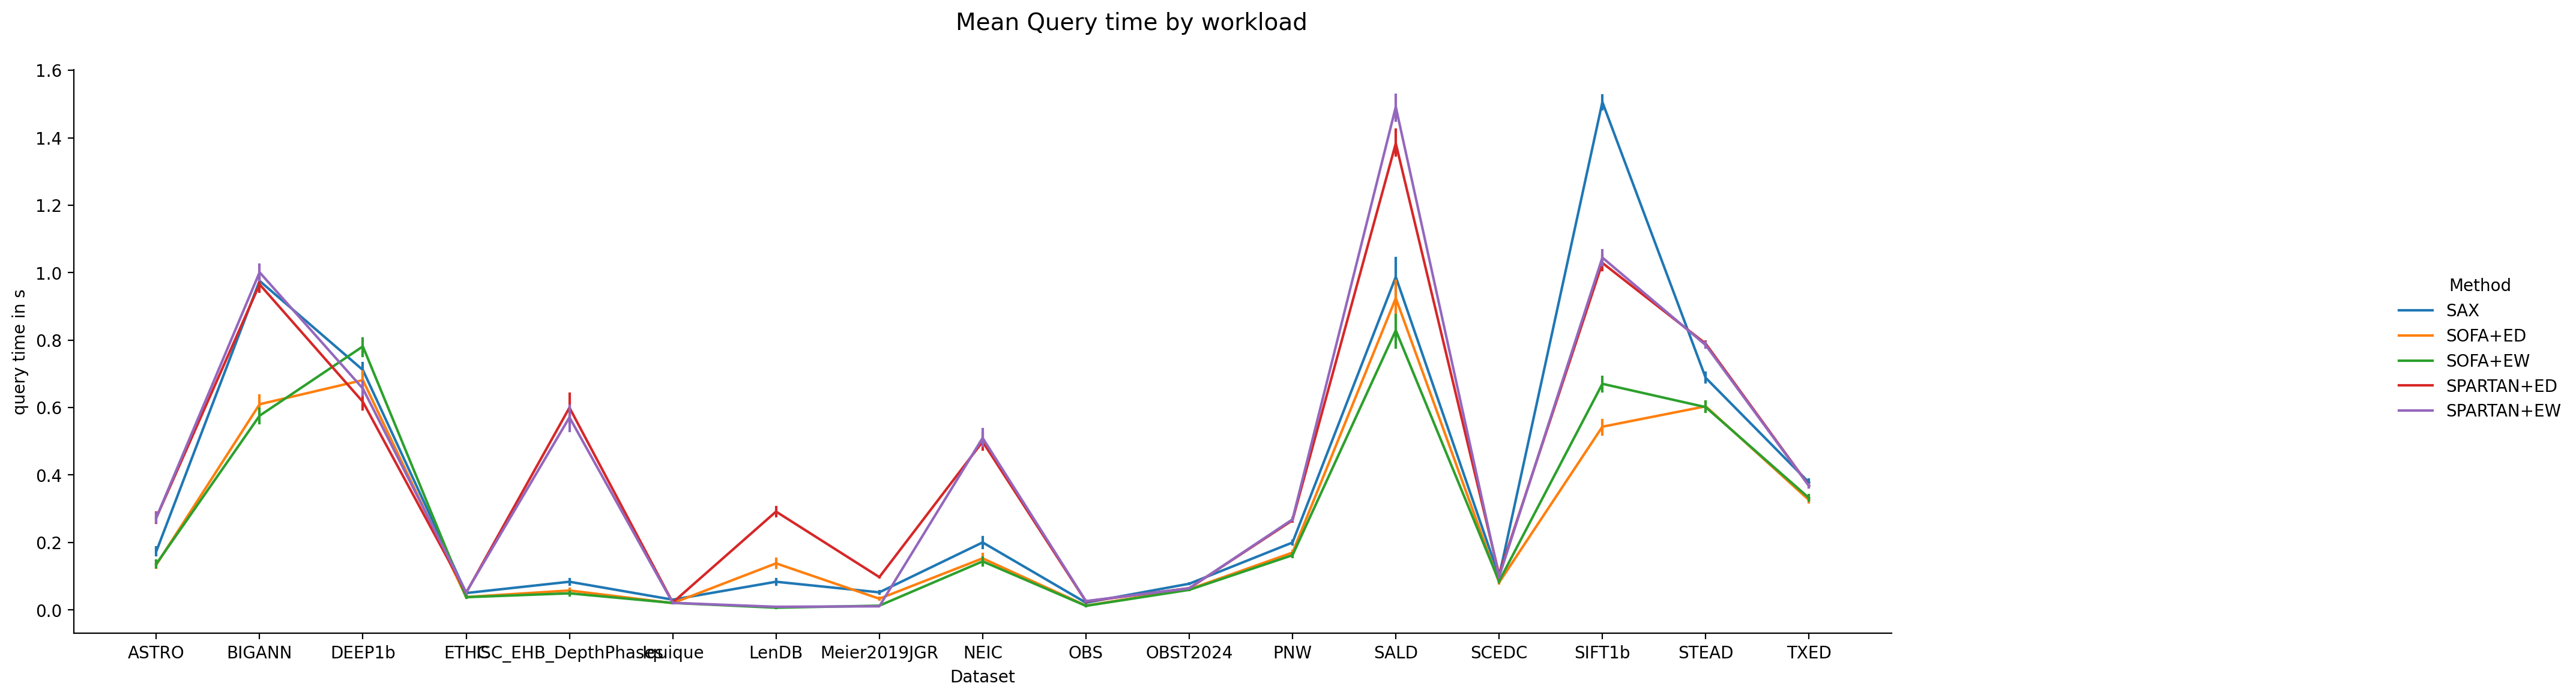

In [23]:
g = sns.relplot(
    x="Dataset", y="query time in s", hue="Method", estimator=np.mean,  
    err_style="bars", 
    facet_kws={'sharey': False, 'sharex': True}, legend="brief",
    data=subset, kind="line", errorbar=('ci', 50))
g.fig.set_figwidth(24)
g.fig.set_figheight(6)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Mean Query time by workload', size=14)
sns.despine()
# ax.set_yscale("log")
plt.savefig("images/experiment_spartan_scalability_mean_all.pdf", bbox_inches='tight')
plt.show()

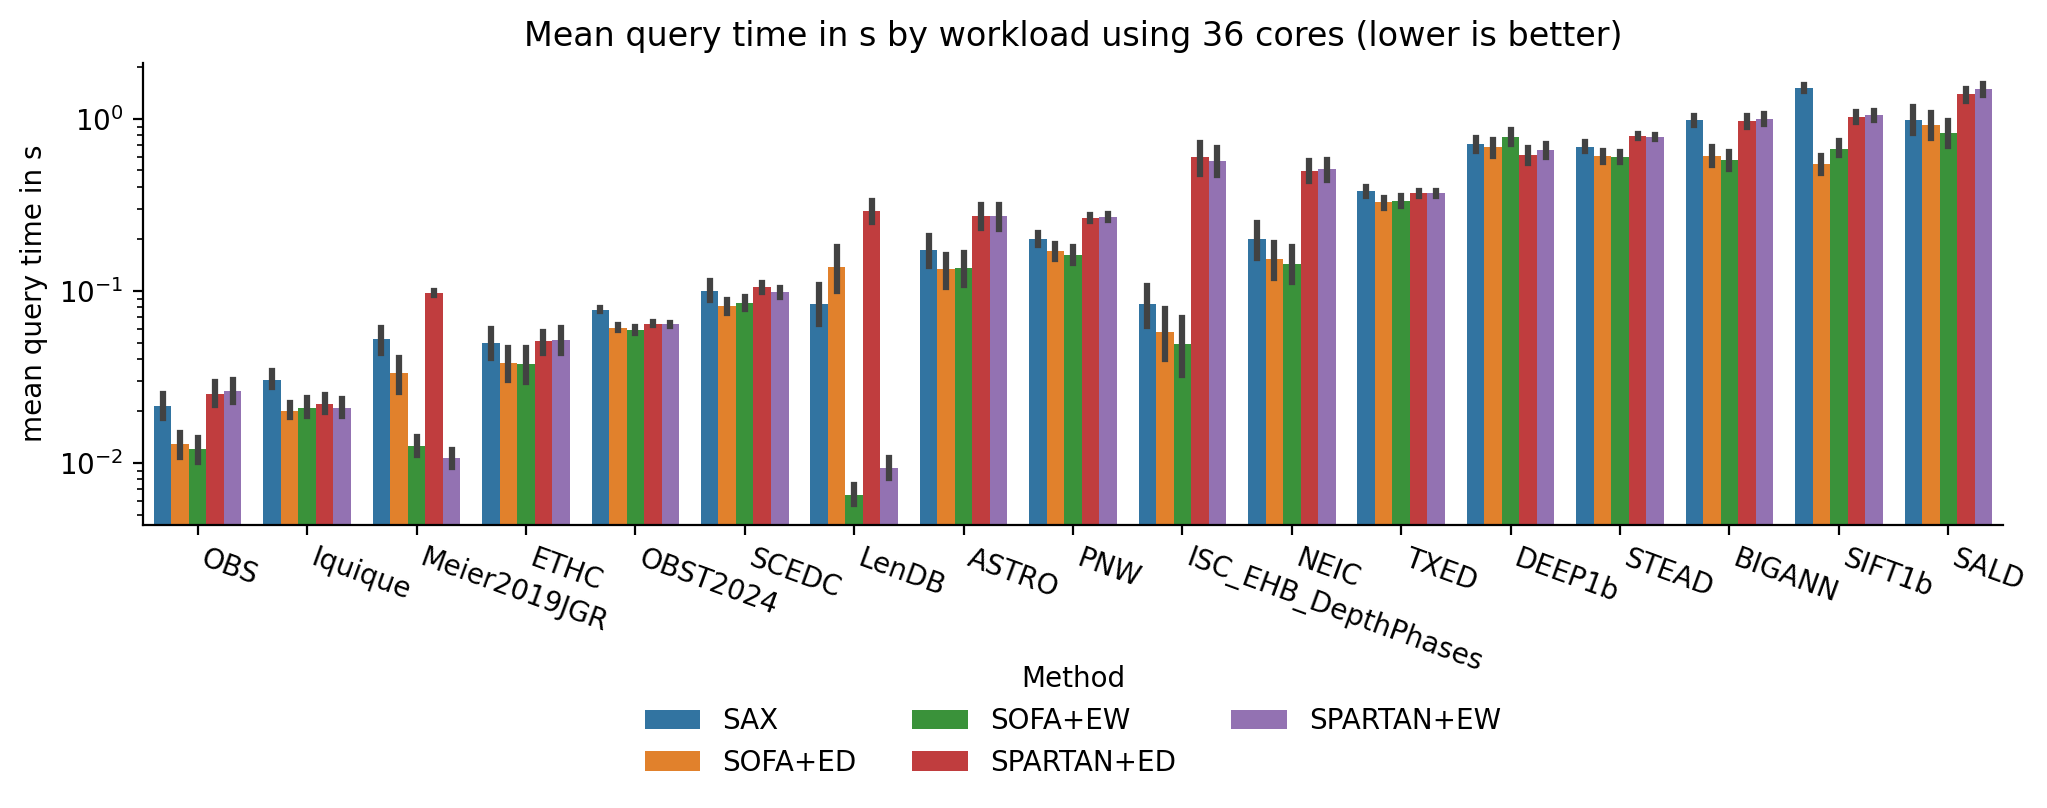

In [28]:
subset.Method = subset.Method.replace("\n","", regex=True)
CORES = "36" 
plot_order = subset.groupby(["Dataset"]) \
        .mean("query time in s").sort_values(by="query time in s")

fig, ax = plt.subplots(figsize=(12,3))
sns.barplot(x="Dataset", 
            y="query time in s", 
            # estimator=np.mean, 
            hue="Method", data=subset[(subset.Cores==CORES)], ax = ax,
            order=plot_order.index
           )
ax.set_title("Mean query time in s by workload using "+str(CORES)+" cores (lower is better)")
# ax.set_xlabel("Dataset (workload)")
ax.set_xlabel("")
ax.set_ylabel("mean query time in s")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.despine()
sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3)  # bbox_to_anchor=(1, 1), 
ax.set_yscale("log")
plt.savefig("images/experiment_spartan_mean_query_time_"+CORES+".pdf", bbox_inches='tight')
plt.show()

/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_93865/2912733704.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda l: l["query time in s"] / (l["query time in s"].iloc[0])).reset_index()
/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_93865/2912733704.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda l: (l["query time in s"].iloc[0]) / l["query time in s"]).reset

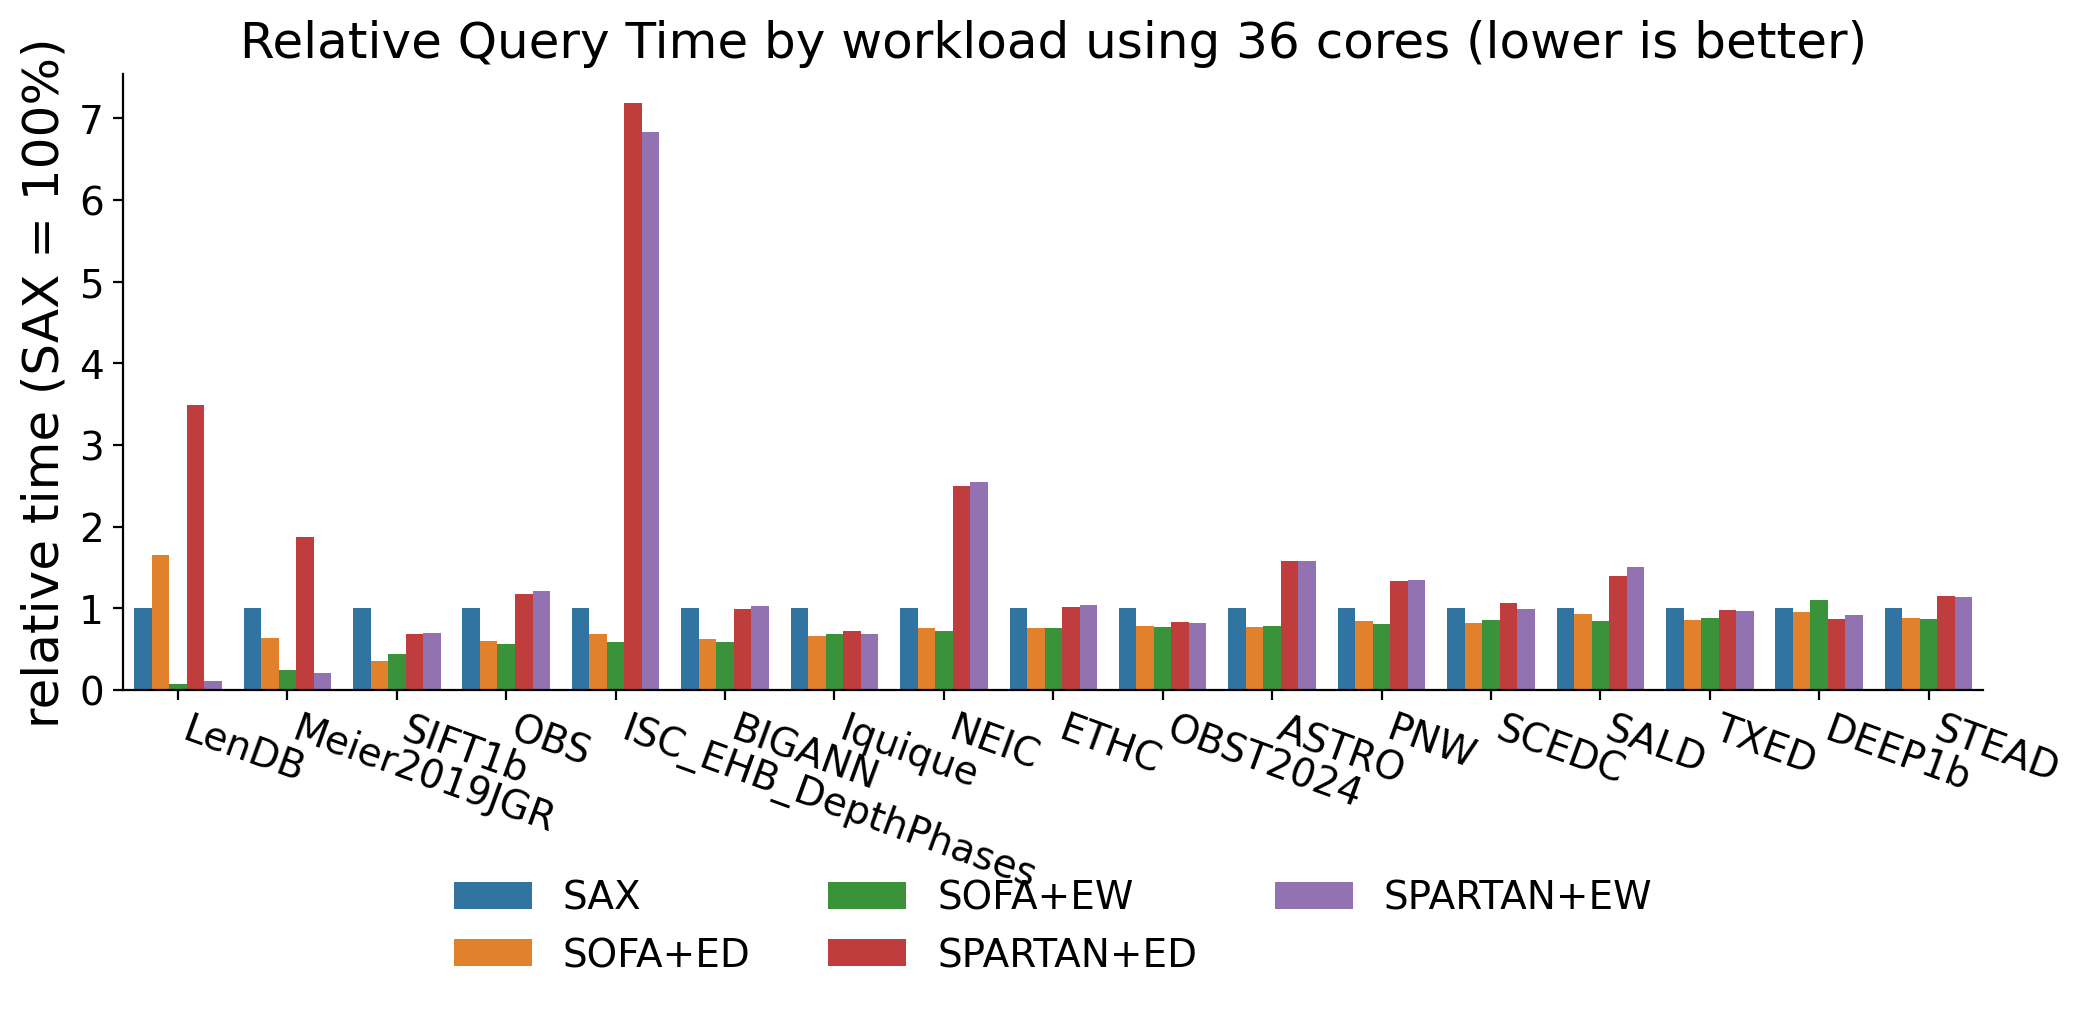

In [35]:
CORES = "36"

df_mean = subset[subset.Cores==CORES].groupby(["Dataset", "Method"])["query time in s"].sum().reset_index()

# l.iloc[0]["query time in s"]
df_normed = df_mean.groupby(["Dataset"]) \
        .apply(lambda l: l["query time in s"] / (l["query time in s"].iloc[0])).reset_index()

df_factor = df_mean.groupby(["Dataset"]) \
        .apply(lambda l: (l["query time in s"].iloc[0]) / l["query time in s"]).reset_index()

plot_order = df_normed.groupby("Dataset").min("query time in s").sort_values(by="query time in s")

df_mean["normed"] = df_normed["query time in s"]
df_mean["factor"] = df_factor["query time in s"]
# display(df_mean)

fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x="Dataset", y="normed",
            hue="Method", data=df_mean, ax = ax,
            order=plot_order.index
           )

legend = ax.legend() # removes the title
#ax.bar_label(ax.containers[1], fmt='{:.2%}', rotation=90, label_type='edge', fontsize=10)
#ax.bar_label(ax.containers[2], fmt='{:.2%}', rotation=90, label_type='edge', fontsize=10)
#ax.bar_label(ax.containers[3], fmt='{:.2%}', rotation=90, label_type='edge', fontsize=10)
#ax.bar_label(ax.containers[4], fmt='{:.2%}', rotation=90, label_type='edge', fontsize=10)
ax.set_title("Relative Query Time by workload using "+str(CORES)+" cores (lower is better)", fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("relative time (SAX = 100%)", fontsize=18)
plt.xticks(rotation=-20, fontsize=14, ha='left')
plt.yticks(fontsize=14)
sns.despine()

sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3, fontsize=14)

plt.savefig("images/experiment_spartan_relative_query_time_"+CORES+".pdf", bbox_inches='tight')
plt.show()        

In [37]:
display(df_mean[df_mean.Method=="SOFA+EW"][["Dataset", "factor"]])

,Dataset,factor
2,ASTRO,1.273343
7,BIGANN,1.694419
12,DEEP1b,0.910526
17,ETHC,1.325821
22,ISC_EHB_DepthPhases,1.699214
27,Iquique,1.465250
32,LenDB,12.822071
37,Meier2019JGR,4.145643
42,NEIC,1.390578
47,OBS,1.787136


In [39]:
display(df_mean[df_mean.Method=="SPARTAN+ED"][["Dataset", "factor"]])

,Dataset,factor
3,ASTRO,0.635059
8,BIGANN,1.010565
13,DEEP1b,1.153067
18,ETHC,0.985598
23,ISC_EHB_DepthPhases,0.139194
28,Iquique,1.384551
33,LenDB,0.286347
38,Meier2019JGR,0.535302
43,NEIC,0.401199
48,OBS,0.852042


/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_93865/996992300.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


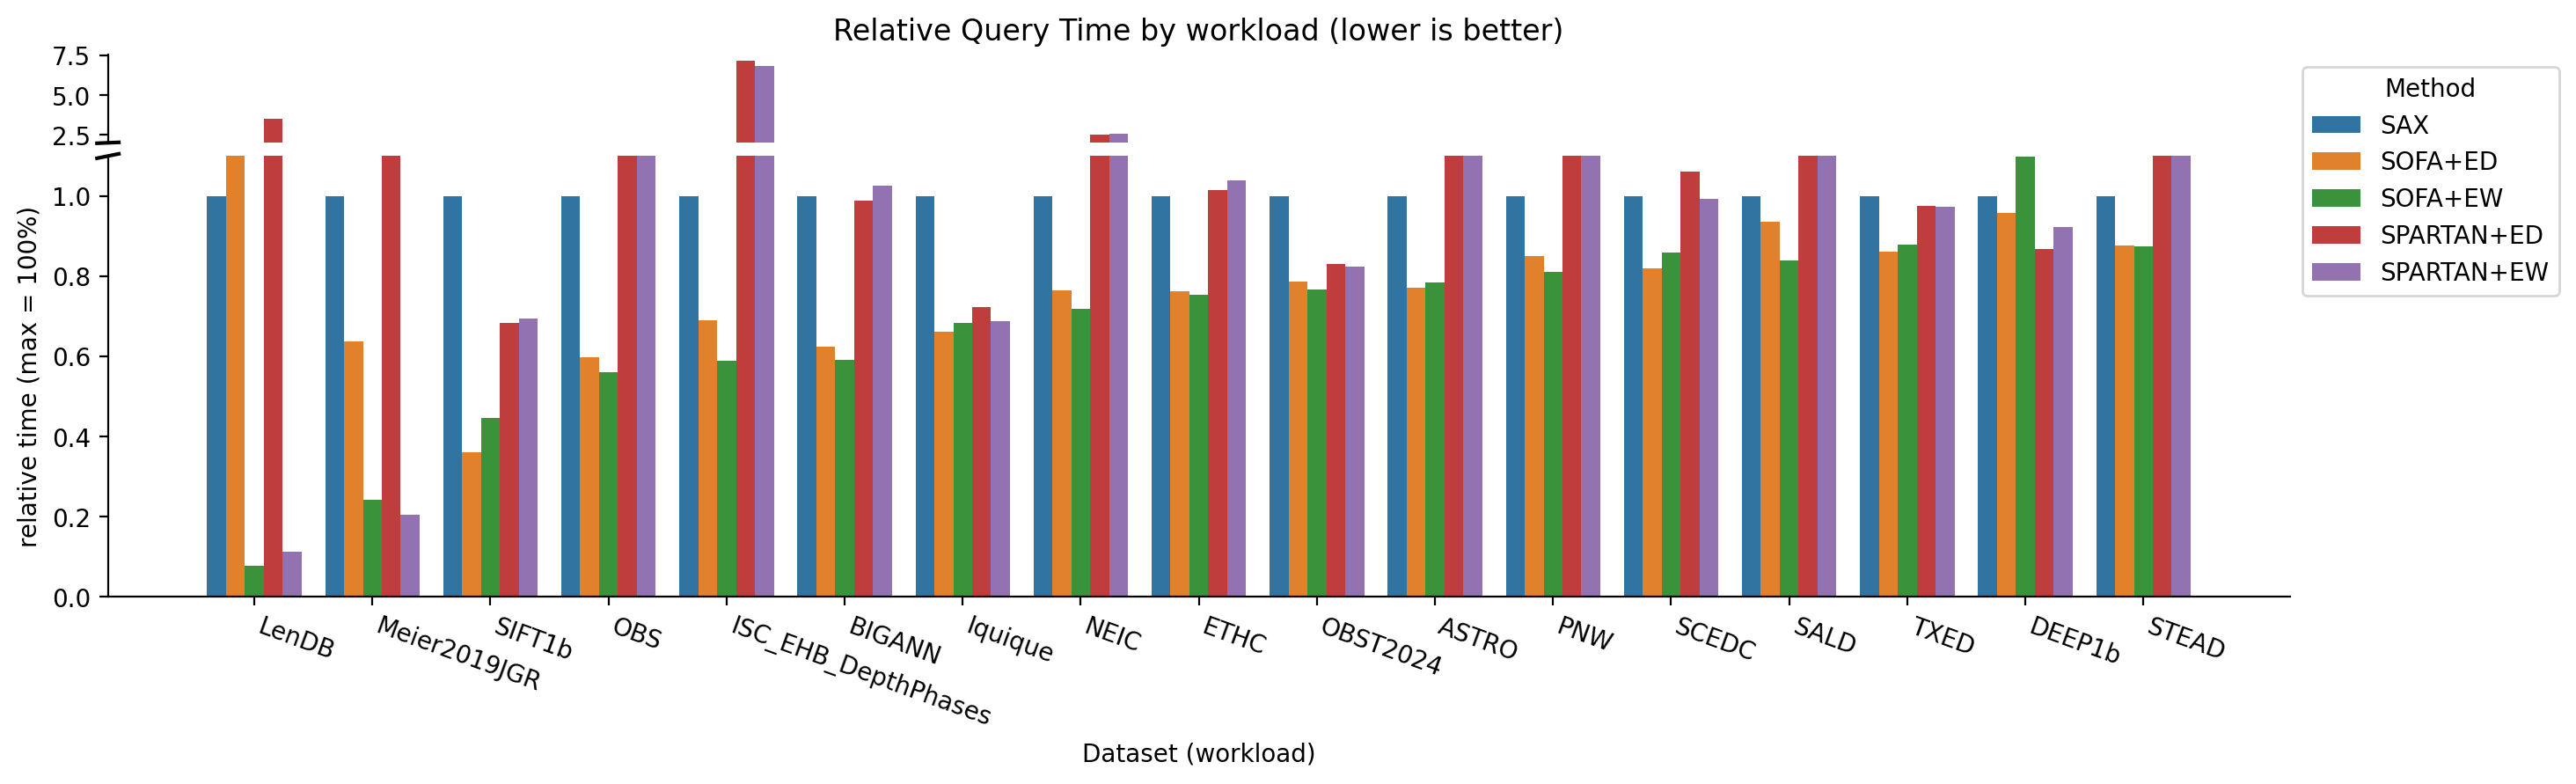

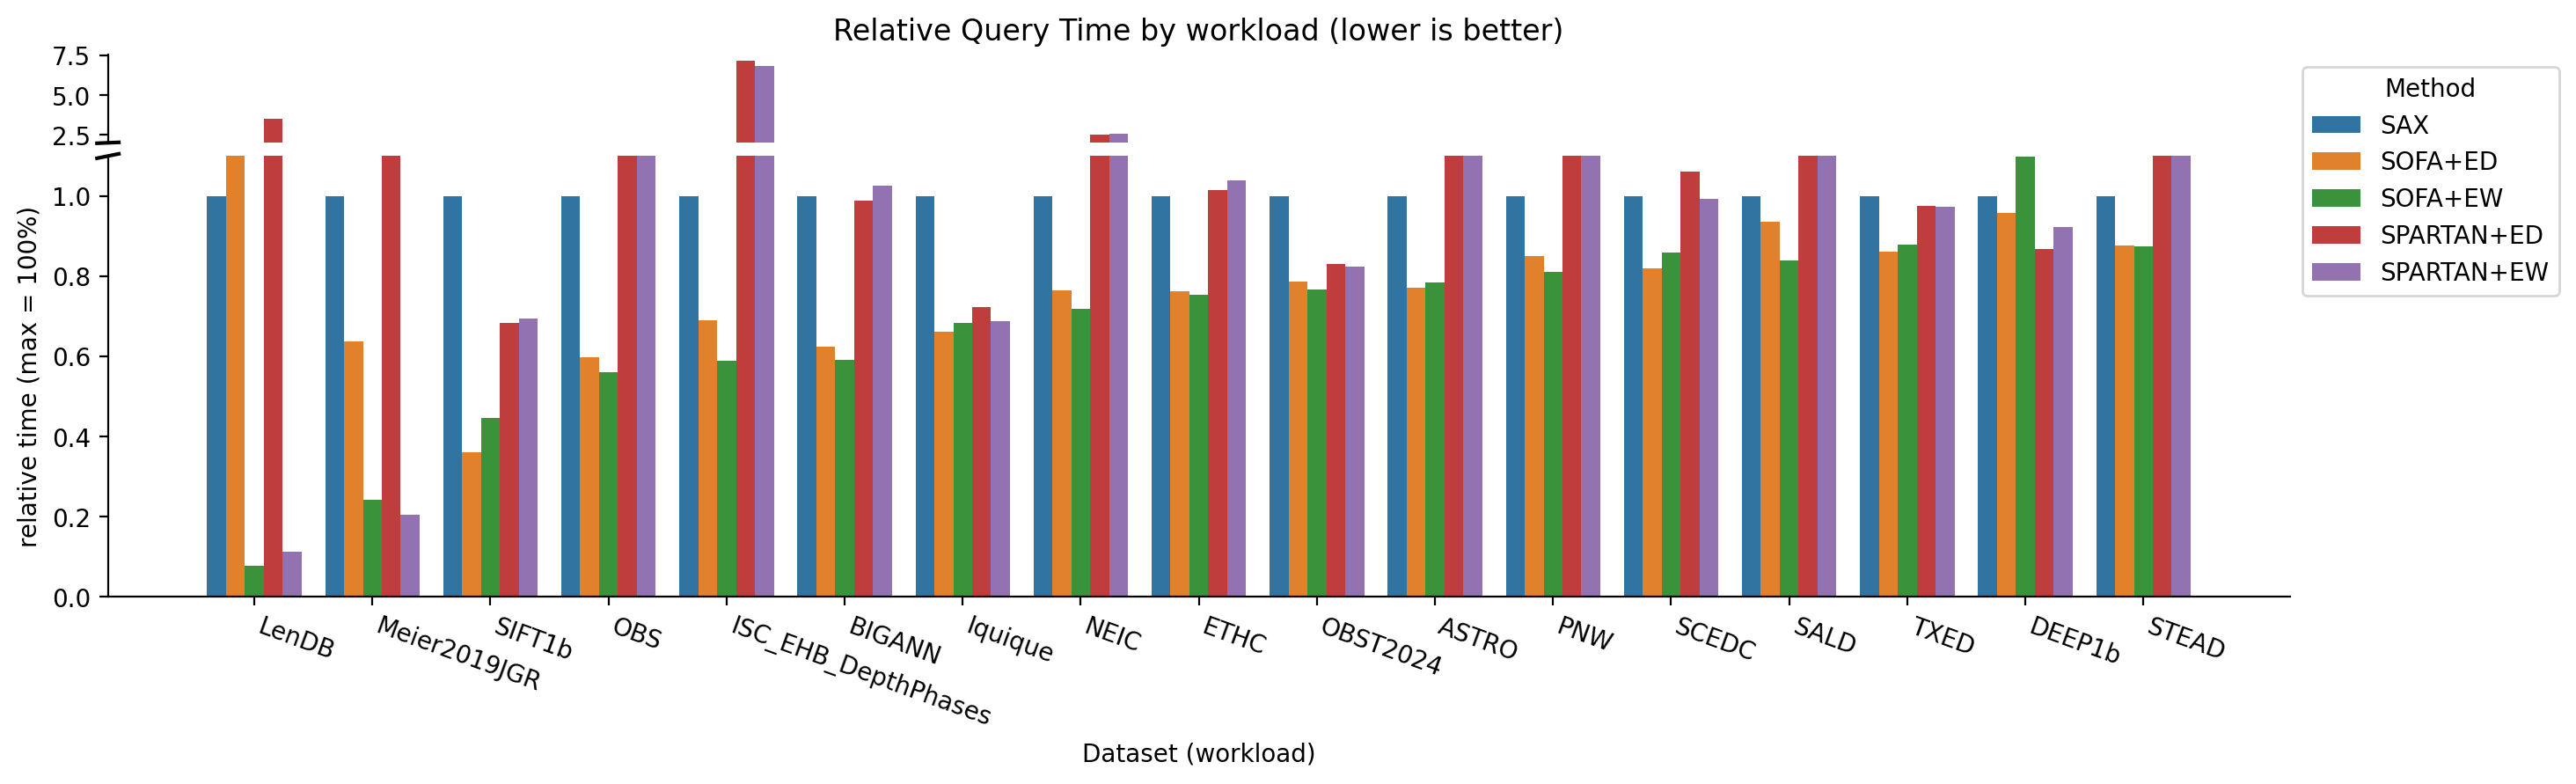

In [41]:
fig, (ax_top, ax_bottom) = plt.subplots(
    ncols=1, nrows=2, # sharex=True, 
    gridspec_kw={'hspace':0.05, 'height_ratios': [1, 5]}, figsize=(16,4))

sns.barplot(x="Dataset", y="normed", hue="Method", data=df_mean, ax = ax_top, order=plot_order.index)
sns.barplot(x="Dataset", y="normed", hue="Method", data=df_mean, ax = ax_bottom, order=plot_order.index)

ax_top.set_ylim(bottom=2.0)
ax_bottom.set_ylim(0, 1.1)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

d = .005
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs)

kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)

#remove one of the legend
ax_bottom.legend_.remove()
ax_top.set_ylabel("")
ax_top.set_xlabel("")
ax_top.set_xticks([])

ax_top.set_title("Relative Query Time by workload (lower is better)")
ax_bottom.set_xlabel("Dataset (workload)")
ax_bottom.set_ylabel("relative time (max = 100%)")
plt.xticks(rotation=-20, fontsize=10, ha='left')
sns.move_legend(ax_top, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.25), ncol=3)  # bbox_to_anchor=(1, 1), 
plt.tight_layout()

# plt.savefig("images/experiment_spartan_relative_query_time.pdf", bbox_inches='tight')
plt.show()

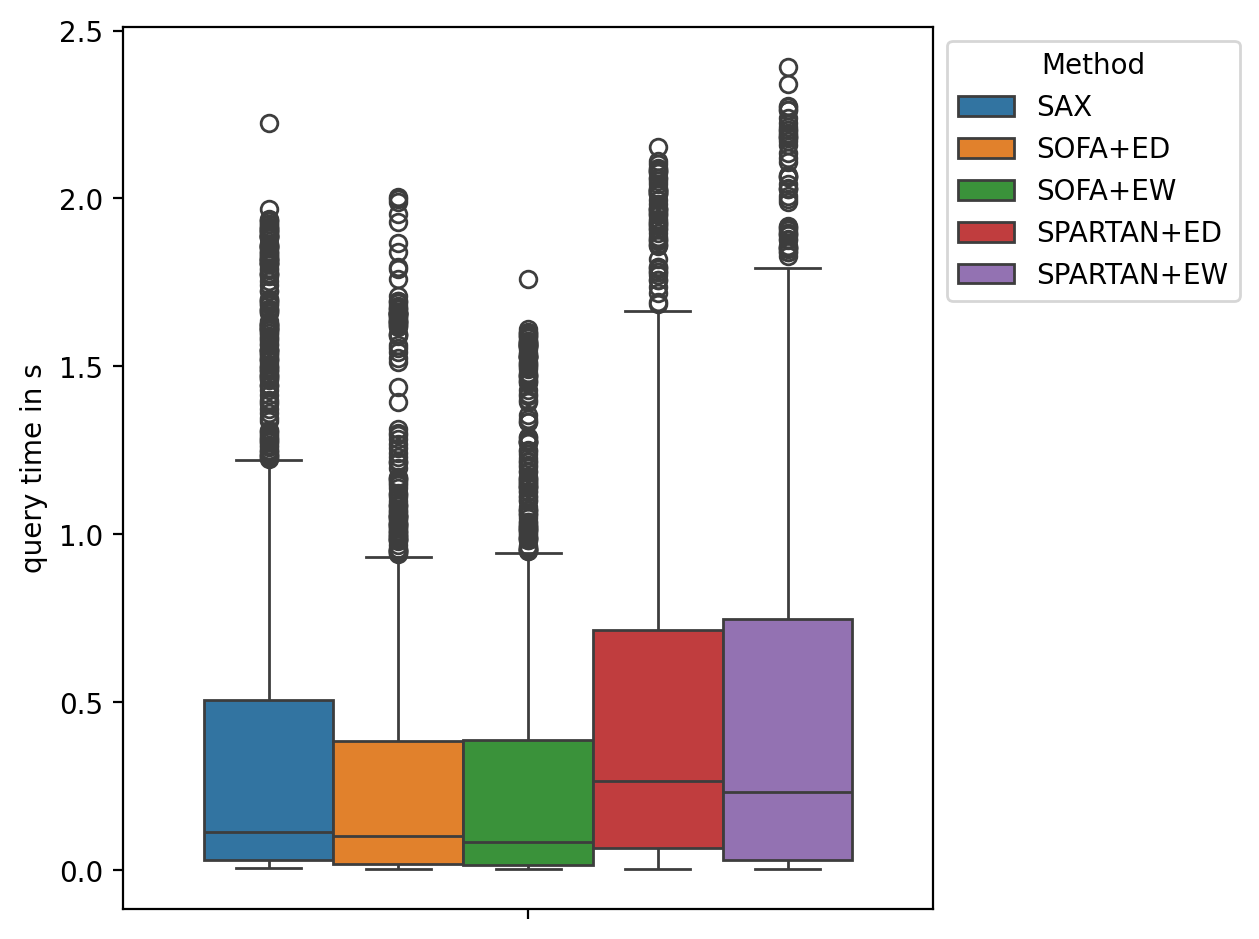

In [55]:
ax = sns.boxplot(hue="Method", y="query time in s", data=subset)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig("images/experiment_spartan_boxplot.pdf", bbox_inches='tight')
plt.show()

In [46]:
result_median = subset.groupby(["Method","Cores"])["query time in s"].median().transform(lambda l: str(np.round(l * 1000))+" ms")
result_median

Method      Cores
SAX         36       112.0 ms
SOFA+ED     36       102.0 ms
SOFA+EW     36        84.0 ms
SPARTAN+ED  36       265.0 ms
SPARTAN+EW  36       233.0 ms
Name: query time in s, dtype: object

In [47]:
result_mean = subset.groupby(["Method","Cores"])["query time in s"].mean().transform(lambda l: str(np.round(l * 1000))+" ms")
result_mean

Method      Cores
SAX         36       372.0 ms
SOFA+ED     36       270.0 ms
SOFA+EW     36       266.0 ms
SPARTAN+ED  36       438.0 ms
SPARTAN+EW  36       426.0 ms
Name: query time in s, dtype: object

In [48]:
result_all = pd.concat([result_median, result_mean], axis=1)
print(result_all.T.to_latex())

\begin{tabular}{llllll}
\toprule
Method & SAX & SOFA+ED & SOFA+EW & SPARTAN+ED & SPARTAN+EW \\
Cores & 36 & 36 & 36 & 36 & 36 \\
\midrule
query time in s & 112.0 ms & 102.0 ms & 84.0 ms & 265.0 ms & 233.0 ms \\
query time in s & 372.0 ms & 270.0 ms & 266.0 ms & 438.0 ms & 426.0 ms \\
\bottomrule
\end{tabular}

